## Implementation

In [244]:
import numpy as np
from scipy.special import digamma
from numba import njit

@njit
def knns_1d(x_srt, k=3, select=None):
    select = np.arange(len(x_srt)) if select is None else select
    nns = np.zeros(len(select), dtype='int')
    left_bounds = np.zeros(len(select), dtype='int')
    right_bounds = np.zeros(len(select), dtype='int')
    for i in range(len(select)):
        nn = i
        left_candidate = i-1
        right_candidate = i+1
        for _ in range(1, k+1):
            # let j be iteration index
            # INV1: nn is index of j-th nearest neighbour
            # INV2: left_candidate is max index less than i of point further away than j-th nearest neighbour
            # INV3: right_candidate is min index greater than i of point further away than j-th nearest neighbour
            if left_candidate == -1:
                nn = right_candidate
                right_candidate += 1
            elif right_candidate == len(select):
                nn = left_candidate
                left_candidate -= 1
            elif x_srt[select[right_candidate]]-x_srt[select[i]] <= x_srt[select[i]] - x_srt[select[left_candidate]]:
                nn = right_candidate
                right_candidate += 1
            else:
                nn = left_candidate
                left_candidate -= 1
        nns[i] = select[nn]
        left_bounds[i] = select[left_candidate+1]
        right_bounds[i] = select[right_candidate-1]
    return nns, left_bounds, right_bounds

@njit
def global_counts_local_knn_dist_1d(x_srt, y, classes=None, k=3):
    classes = np.unique(y) if classes is None else classes
    counts = np.zeros_like(x_srt, 'int')
    for c in classes:
        selection = np.flatnonzero(y==c)
        _, left_bounds, right_bounds = knns_1d(x_srt, k, select=selection)
        counts[selection] = right_bounds - left_bounds
    return counts

def knn_mi_1d(x, y, k=3):
    x = x.reshape(-1, 1) if len(x.shape)==1 else x
    order = np.argsort(x, axis=0)
    n, p = x.shape
    res = np.zeros(p)
    classes, class_counts = np.unique(y, return_counts=True)
    for j in range(p):
        x_srt = x[:, j][order[:, j]]
        y_srt = y[order[:, j]]
        counts = global_counts_local_knn_dist_1d(x_srt, y_srt, classes=classes, k=k)
        res[j] = digamma(n) - digamma(class_counts).mean() + digamma(k) - digamma(counts).mean()
    return res



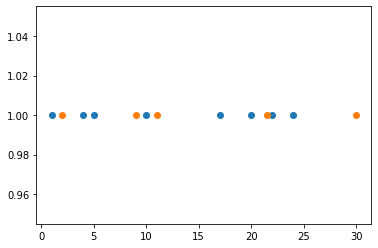

In [168]:
from matplotlib import pyplot as plt
test_x = np.array([10, 1, 21.5, 22, 30, 11, 20, 5, 9, 17, 4, 24, 2])
test_y = np.array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

for i in np.unique(test_y):
    plt.scatter(test_x[test_y==i], np.ones(len(test_x[test_y==i])))
plt.show()

In [242]:
order = np.argsort(test_x)
global_counts_local_knn_dist_1d(test_x[order], test_y[order])

array([5, 8, 5, 5, 8, 5, 8, 4, 4, 8, 4, 4, 8])

## Gaussian Mixture Test Case

In [246]:
import numpy as np

def make_gaussian_mixture_data(n=10, k=2, means=[np.array([-1]), np.array([1])], covs=None, class_probs=None, random_state=None):
    RNG = np.random.default_rng(seed=random_state)
    d = len(means[0])
    class_probs=np.ones(k)/k if class_probs is None else class_probs
    _, y = np.nonzero(RNG.multinomial(1, class_probs, size=n))

    covs = [np.eye(d) for _ in range(k)] if covs is None else covs
    x = np.zeros(shape=(n, d))

    for i in range(k):
        idx_i = np.flatnonzero(y==i)
        x[idx_i] = RNG.multivariate_normal(means[i], covs[i], size=len(idx_i))

    return x, y

make_gaussian_mixture_data(random_state=0)


(array([[-1.62327446],
        [ 0.68369984],
        [ 1.41163054],
        [ 2.04251337],
        [-0.95867402],
        [-3.32503077],
        [-1.21879166],
        [-2.24591095],
        [-1.73226735],
        [-1.54425898]]),
 array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0]))

In [51]:
x, y = make_gaussian_mixture_data(200)

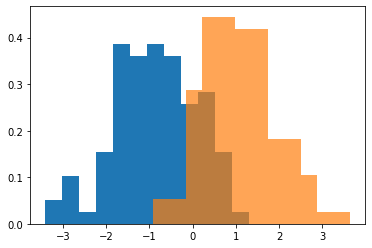

In [52]:
plt.hist(x[y==0], bins=12, density=True)
plt.hist(x[y==1], bins=12, density=True, alpha=0.7)
plt.show()

In [253]:
%timeit knns_1d(x)

86.5 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [247]:
knn_mi_1d(x, y)

array([0.46673608])

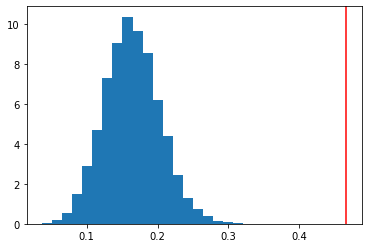

In [254]:
RNG = np.random.default_rng(seed=0)
reps = 10000
null_samples = np.zeros(reps)
for r in range(reps):
    permutation = RNG.choice(len(y), len(y), replace=False)
    y[permutation]
    null_samples[r] = knn_mi_1d(x, y[permutation])[0]

pvalue = sum(null_samples >= knn_mi_1d(x, y)[0])/len(null_samples)

plt.hist(null_samples, bins=20, density=True)
plt.axvline(knn_mi_1d(x, y)[0], color='red')
plt.show()